# Notebook to assess accuracy of an offline, volume-integrated heat budget for TXLA model output. 
## Dropping the overbar and primes used in the standard Reynolds averaged tracer equations, the potential temperature equation $T$ may be written as 
### $\frac{\partial T}{\partial t}+ \textbf{u} \cdot \nabla T =\nabla_H \cdot (\kappa_H \nabla_H T)+  \frac{\partial}{\partial z} \left(\kappa_V {\frac{\partial T}{\partial z}} \right),$
where 
>- $T$ is the temperature, 
>- $\mathbf{u}$ is the 3D velocity vector, 
>- $\kappa_H$ is the lateral eddy diffusivity,
>- $\kappa_V$ is the vertical eddy diffusivity. 

Locally, each collective term  has units of degrees C per second. The vertical boundary conditions are written as 
<br>
### $\kappa_V  \left(\frac{\partial T}{\partial z}\right)=\frac{Q_{net}}{\rho_0 C_p}$ @ $z=\eta$ ,
### $\kappa_V  \left(\frac{\partial T}{\partial z}\right)=0$ @ $z=-h$,
where 
>- $C_p$ is the specific heat of seawater [J/kg/deg C]. 
>    > - $C_p=3985$ for COAWST ver. 3.8 COAWST/ROMS/Modules/mod_scalars.F. See https://github.com/DOI-USGS/COAWST/blob/892f4bdd8fede921381096656393084e1eead448/ROMS/Modules/mod_scalars.F#L2
>- $Q_{net}=Q_{sho}+Q_{lon}+Q_{sen}+Q_{lat}$ is the surface net heat flux [W/m$^2$] with four components:
>   > - $Q_{sho}$ is the shortwave flux [W/m$^2$]
>   > - $Q_{lon}$ is the longwave flux [W/m$^2$]
>   > - $Q_{sen}=\rho_{a}c_{pa} C_s U(T_{ocn}-T_{air})$ is the sensible heat flux [W/m$^2$] with air density $\rho_a$, $c_{pa}$ is the specific heat capacity of air, $C_s$ is a turbulent exchange coefficient for sensible heat, and $T_{ocn}$ and $T_{air}$ are the ocean and water temperatures, respectively.
>   > - $Q_{lat}=\rho_{a}L_{v} C_l U(q_{ocn}-q_{air})$ is the latent heat flux [W/m$^2$] with latent heat of vaporization $L_v$, turbulent exchange coefficient for latent heat $C_l$, and $q_*$ refers to the humidity difference between the ocean and atmosphere. 
>- $\eta$ is the free surface
>- $h$ is the depth of the seafloor 

After volume-integrating over a control volume extending from the ocean bottom to the sea surface, we have 
### $\iiint \partial_t T \, dV + \iint (\mathbf{u}T) \cdot \hat{n} \, dA = \frac{Q_{net}}{\rho_0 C_p}$.

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

## Open model output 

In [2]:
tslice = slice('2010-06-10','2010-06-16')
etaslice = slice(273,373)
xislice = slice(423,512)

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_dia_child_0000*.nc') # We do have them for 2010
ds = xr.open_mfdataset(path, chunks = {'ocean_time':1})
ds = ds.sel(ocean_time=tslice)

path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_avg_child_*.nc')
dsa = xroms.open_mfnetcdf(path1, chunks = {'ocean_time':1})
dsa, grida = xroms.roms_dataset(dsa, Vtransform = 2)
dsa = dsa.sel(ocean_time=tslice)

In [5]:
def states_coastline(ax, resolution='10m', linewidth=0.5, color='black', states=True):
	ax.coastlines(resolution=resolution, color=color, linewidth=linewidth)

	states_provinces = cfeature.NaturalEarthFeature(
		    category='cultural',
		    name='admin_1_states_provinces_lakes',
		    scale=resolution,
		    facecolor='none')
	if states:	    
		ax.add_feature(states_provinces, edgecolor=color, linewidth=linewidth)
        
# Box for the location of the cruise
lon = np.array([-92.9,-92.6])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

## Plot the broader location of the cruise and the approximation in model coordinates needed to close the budget 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/d2/home/dylan/.conda/envs/copano/lib/py

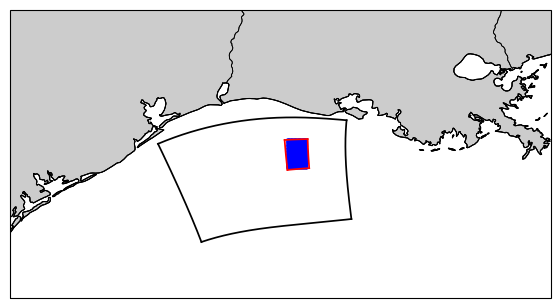

In [6]:
etaslice = slice(273,460)#slice(273,460)
xislice = slice(423,515)#slice(423,512)

fig, ax = plt.subplots(1, figsize = (1.83*2*1.5,1.52*1.3*1.5), subplot_kw={'projection': crs}, constrained_layout = True)

ax.plot(dsa.lon_rho[0,:], dsa.lat_rho[0,:], 'k', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(dsa.lon_rho[:,0], dsa.lat_rho[:,0], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(dsa.lon_rho[:,-1], dsa.lat_rho[:,-1], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(dsa.lon_rho[-1,:], dsa.lat_rho[-1,:], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.plot(dsa.lon_rho.where(box), dsa.lat_rho.where(box), 'b', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.plot(dsa.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[0,:], 
        dsa.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[0,:], 
        'r', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(dsa.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[:,0], 
        dsa.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[:,0], 
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(dsa.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[:,-1],
        dsa.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[:,-1],
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(dsa.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[-1,:],
        dsa.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[-1,:],
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
# ax.set_extent([-100, -70, 16, 44], ccrs.PlateCarree())
ax.set_extent([-97, -89, 27, 31], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect('auto')

## Compute the temp. budget online with diagnostic files. 
See link for discussion on how to do this on the ROMS forums. https://www.myroms.org/forum/viewtopic.php?t=2420

In [7]:
dTdt = (ds.temp_rate*dsa.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
hadv = (ds.temp_hadv*dsa.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vadv = (ds.temp_vadv*dsa.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv
hdiff = (ds.temp_hdiff*dsa.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vdiff = (ds.temp_vdiff*dsa.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
diffusion = hdiff+vdiff

#### Label terms, save as a netcdf because the calculation is very slow 

In [9]:
dTdt.name = 'dTdt'
hadv.name = 'hadv'
vadv.name = 'vadv'
T_adv.name = 'T_adv'
hdiff.name = 'hdiff'
vdiff.name = 'vdiff'
diffusion.name = 'diffu'
ds_dia = xr.merge([dTdt,hadv,vadv,T_adv,hdiff,vdiff,diffusion])
ds_dia.to_netcdf('heat_budget_june_10_16_2010.nc')

## Compute the temp. budget offline with average files.
See link that this driver code was based on or Schlichting et al. (2023) *JAMES*. https://github.com/dylanschlichting/numerical_mixing

In [11]:
#Tendency term - centered finitie difference  
temp = dsa.temp.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).values
delta = dsa.dV.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).values

tempv = temp*delta
dtempvdt = (((tempv)[2:] - (tempv)[:-2])/(2*3600)) #2*dt,dt = 3600 s/hr
dtempvdt_v =  dtempvdt/(delta[1:-1])
dTdt_of = (dtempvdt_v*delta[1:-1]).sum(axis = (1,2,3))

In [12]:
# Advection term 
dydzt = grida.interp((dsa.dy*dsa.dz*dsa.temp), 'X')
dxdzt = grida.interp((dsa.dx*dsa.dz*dsa.temp), 'Y')

utflux = (dydzt*dsa.u).sel(ocean_time=tslice)
vtflux = (dxdzt*dsa.v).sel(ocean_time=tslice)

uflux = utflux.isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
vflux = vtflux.isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

QtW = uflux.isel(xi_u = 0) #West
QtE = uflux.isel(xi_u = -1) #East
QtN = vflux.isel(eta_v = -1) #North
QtS = vflux.isel(eta_v = 0) #South

#Name individual components in case histograms are made, which require the variables be named
QtW.name = 'QW'
QtE.name = 'QE'
QtN.name = 'QN'
QtS.name = 'QS'

Qtds = xr.merge([QtW, QtE, QtN, QtS], compat='override')

tadv_of = (-(Qtds.QW.sum(['eta_rho', 's_rho'])-Qtds.QE.sum(['eta_rho', 's_rho']) \
                 +Qtds.QS.sum(['xi_rho', 's_rho'])-Qtds.QN.sum(['xi_rho', 's_rho']))).load()

In [14]:
# Vertical diffusion term 
rho0 = 1025
cp = 3985
vdiff_of = ((dsa.shflux/(rho0*cp))*dsa.dA).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho']).load()

## Plot online budget 

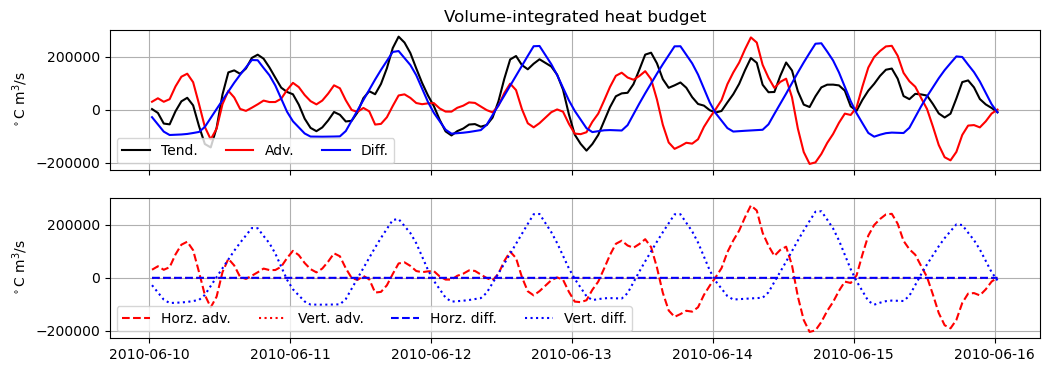

In [40]:
ds_dia = xr.open_dataset('heat_budget_june_10_16_2010.nc')

fig, ax = plt.subplots(2,1, figsize = (12,4), sharey=True)

ax[0].plot(ds_dia.dTdt.ocean_time, ds_dia.dTdt, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(ds_dia.dTdt.ocean_time, ds_dia.T_adv, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(ds_dia.dTdt.ocean_time, ds_dia.diffu, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-integrated heat budget')
ax[1].plot(ds_dia.dTdt.ocean_time, ds_dia.hadv, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(ds_dia.dTdt.ocean_time, ds_dia.vadv, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(ds_dia.dTdt.ocean_time, ds_dia.hdiff, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(ds_dia.dTdt.ocean_time, ds_dia.vdiff, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C m$^3$/s')

In [18]:
print('Bulk horz/total adv [%]', ds_dia.hadv.sum().values/(ds_dia.T_adv.sum().values)*100)
print('Bulk horz/total diff [%]', ds_dia.hdiff.sum().values/(ds_dia.diffu.sum().values)*100)

Bulk horz/total adv [%] 100.00000022210828
Bulk horz/total diff [%] 0.014180826201914725


### Lateral diffusion is negligible, barely more than a fraction of a percent. Discard for future analysis. 

## Directly compare on- and offline calculations 

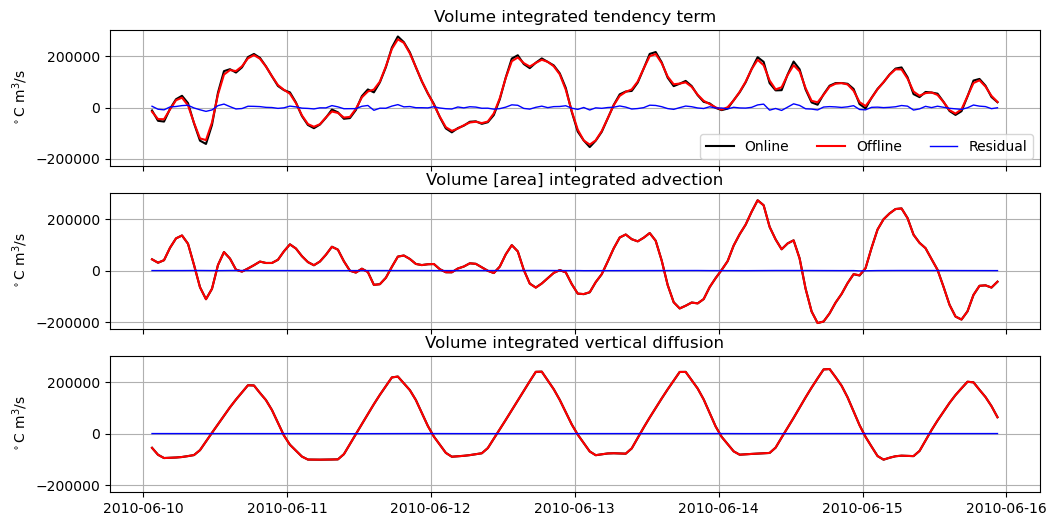

In [47]:
fig, ax = plt.subplots(3,1, figsize = (12,6), sharey=True)

ax[0].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.dTdt[1:-2], label = 'Online', lw = 1.5, c = 'k')
ax[0].plot(ds_dia.dTdt.ocean_time[1:-2], dTdt_of[:-1], label = 'Offline', lw = 1.5, c = 'r')
ax[0].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.dTdt[1:-2]-dTdt_of[:-1], label = 'Residual', lw = 1, c = 'b')
ax[0].legend(loc='best', ncol = 4)

ax[1].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.T_adv[1:-2], lw = 1.5, c = 'k')
ax[1].plot(ds_dia.dTdt.ocean_time[1:-2], -tadv_of[1:-2], lw = 1.5, c = 'r')
ax[1].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.T_adv[1:-2]+tadv_of[1:-2], lw = 1, c = 'b')

ax[2].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.diffu[1:-2], lw = 1.5, c = 'k')
ax[2].plot(ds_dia.dTdt.ocean_time[1:-2], vdiff_of[1:-2], lw = 1.5, c = 'r')
ax[2].plot(ds_dia.dTdt.ocean_time[1:-2], ds_dia.diffu[1:-2]-vdiff_of[1:-2], lw = 1, c = 'b')

ax[0].set_title('Volume integrated tendency term')
ax[1].set_title('Volume [area] integrated advection')
ax[2].set_title('Volume integrated vertical diffusion')

for i in range(3):
    ax[i].grid(which='both')
    ax[i].set_ylabel(r'$^\circ$C m$^3$/s')
for i in range(2):
    ax[i].set_xticklabels('')

In [56]:
print('Bulk online/offline tendency term [%]', ds_dia.dTdt[1:-2].sum().values/(dTdt_of[:-1].sum())*100)
print('Bulk online/offline advection term [%]', ds_dia.T_adv.sum().values/(-tadv_of.sum().values)*100)
print('Bulk online/offline diffusion term [%]', ds_dia.diffu.sum().values/(vdiff_of.sum().values)*100)

Bulk online/offline tendency term [%] 99.99625530958286
Bulk online/offline advection term [%] 95.27763719678147
Bulk online/offline diffusion term [%] 100.01523573497555


## So the tendency term has the largest instantaneous error but is acceptable for offline analysis